# Deeper architectures

With these popular deep architectures the challenge was finding the optimal number of parameters (through setting of number of filters, removing layers, blocks, ...) and tuning their optimalization.

`**Disclaimer** this notebook is a summary of multiple experiments created to present the explorative process. We omited data loading and preprocessing, etc. For full, functioning notebooks see the 'examples' included.`

## ResNet

The ResNet implementation used in experiments is inspired by Dorian Lazar and his code shared on towardsdatascience.com

source: [https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba](https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba)


### ResNet 1 *(AP100: 0.47, params: 846,469)*

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size=3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)

    return out

def create_res_net():
    
    inputs = Input(shape=(50, 20, 1))
    num_filters = 32
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = Dropout(0.20)(t)
    
    num_blocks_list = [2, 4, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            t = Dropout(0.20)(t)

        num_filters *= 2

    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(1, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    return model

In [ ]:
with strategy.scope():

  model = create_res_net()
  model.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_40 (BatchN  (None, 50, 20, 1)   4           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_44 (Conv2D)             (None, 50, 20, 32)   320         ['batch_normalization_40[0][0]'] 
                                                                                                  
 re_lu_36 (ReLU)                (None, 50, 20, 32)   0           ['conv2d_44[0][0]']        

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.01, 
        patience=40, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
# # Compute class-weights
# n = 1515000
# c = 2
# n_positive = 15000
# n_negative = 1500000

# weight_positive = n / (c * n_positive)
# weight_negative = n / (c * n_negative)

# print(f"Using class weights:\npositive: {weight_positive},\nnegative: {weight_negative}")

In [ ]:
history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])),

    shuffle=True,
    batch_size=128*8,

    # class_weight={
    #     0: 1,
    #     1: 100
    # },

    validation_split=0.05,

    # x=train_generator,
    # validation_data=val_generator, 
    verbose=1,
    epochs=120,
    callbacks=callbacks
    )

Epoch 1/120
293/293 [==============================] - 42s 87ms/step - loss: 0.2221 - precision: 0.1512 - recall: 0.1113 - val_loss: 0.2776 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/120
293/293 [==============================] - 12s 42ms/step - loss: 0.1341 - precision: 0.6293 - recall: 0.2962 - val_loss: 1.4918 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/120
293/293 [==============================] - 12s 42ms/step - loss: 0.1179 - precision: 0.6717 - recall: 0.3702 - val_loss: 0.1111 - val_precision: 0.6452 - val_recall: 0.5535
Epoch 4/120
293/293 [==============================] - 12s 41ms/step - loss: 0.1019 - precision: 0.7202 - recall: 0.4637 - val_loss: 0.1103 - val_precision: 0.6059 - val_recall: 0.5899
Epoch 5/120
293/293 [==============================] - 12s 41ms/step - loss: 0.1015 - precision: 0.7172 - recall: 0.4677 - val_loss: 0.1079 - val_precision: 0.6394 - val_recall: 0.6201
Epoch 6/120
293/293 [==============================] - 12s 

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


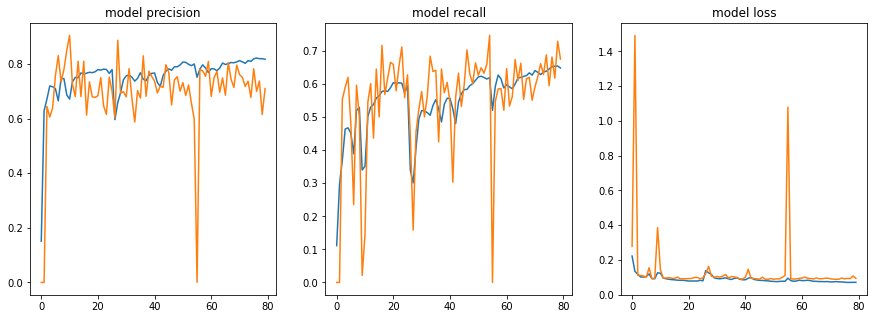

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15,5))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
ax[0].plot(history.history['precision'])
ax[0].plot(history.history['val_precision'])
ax[0].set_title('model precision')
# ax[0].ylabel('precision')
# ax[0].xlabel('epoch')
# ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for accuracy
ax[1].plot(history.history['recall'])
ax[1].plot(history.history['val_recall'])
ax[1].set_title('model recall')
# ax[1].ylabel('recall')
# ax[1].xlabel('epoch')
# ax[1].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[2].plot(history.history['loss'])
ax[2].plot(history.history['val_loss'])
ax[2].set_title('model loss')
# ax[2].ylabel('loss')
# ax[2].xlabel('epoch')
# ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

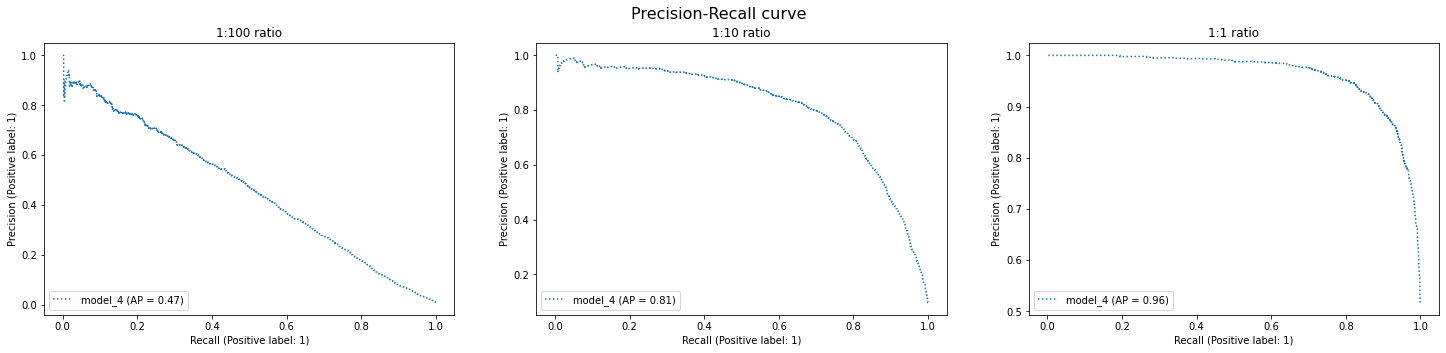

In [ ]:
test_and_plot([model], test_data_1, test_data_10, test_data_100)

### ResNet 2 *(AP100: 0.49, params: 1,476,357)*

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size=3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)

    return out

def create_res_net():
    
    inputs = Input(shape=(50, 20, 1))
    num_filters = 32
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = Dropout(0.25)(t)
    
    num_blocks_list = [4, 4, 4]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            t = Dropout(0.25)(t)

        num_filters *= 2

    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(1, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    return model

In [ ]:
with strategy.scope():

  model = create_res_net()
  model.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_26 (BatchN  (None, 50, 20, 1)   4           ['input_2[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_27 (Conv2D)             (None, 50, 20, 32)   320         ['batch_normalization_26[0][0]'] 
                                                                                                  
 re_lu_25 (ReLU)                (None, 50, 20, 32)   0           ['conv2d_27[0][0]']        

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=40, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])),

    shuffle=True,
    batch_size=128*8,

    # class_weight={
    #     0: 1,
    #     1: 100
    # },

    validation_split=0.05,

    # x=train_generator,
    # validation_data=val_generator, 
    verbose=1,
    epochs=120,
    callbacks=callbacks
    )

Epoch 1/120
432/432 [==============================] - 61s 90ms/step - loss: 0.1389 - precision: 0.2175 - recall: 0.1380 - val_loss: 0.1444 - val_precision: 1.0000 - val_recall: 0.0225
Epoch 2/120
432/432 [==============================] - 22s 52ms/step - loss: 0.0870 - precision: 0.6692 - recall: 0.3268 - val_loss: 0.0841 - val_precision: 0.7986 - val_recall: 0.3038
Epoch 3/120
432/432 [==============================] - 22s 50ms/step - loss: 0.1076 - precision: 0.4746 - recall: 0.3977 - val_loss: 0.3501 - val_precision: 0.0628 - val_recall: 0.1863
Epoch 4/120
432/432 [==============================] - 22s 50ms/step - loss: 0.1269 - precision: 0.3485 - recall: 0.1577 - val_loss: 0.0965 - val_precision: 0.7460 - val_recall: 0.1863
Epoch 5/120
432/432 [==============================] - 22s 51ms/step - loss: 0.0902 - precision: 0.6550 - recall: 0.3072 - val_loss: 0.0865 - val_precision: 0.7925 - val_recall: 0.2523
Epoch 6/120
432/432 [==============================] - 22s 52ms/step - loss

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


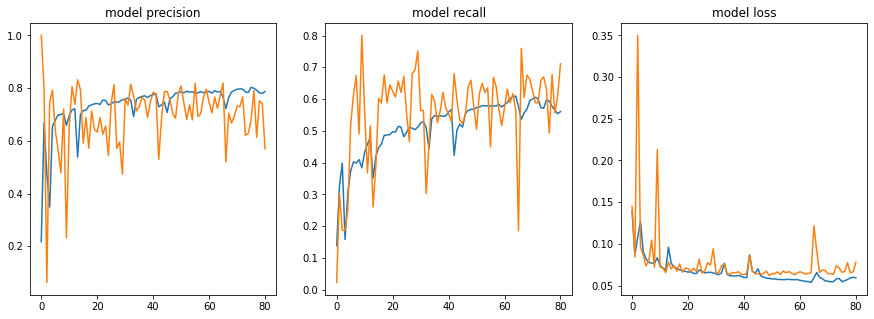

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15,5))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
ax[0].plot(history.history['precision'])
ax[0].plot(history.history['val_precision'])
ax[0].set_title('model precision')
# ax[0].ylabel('precision')
# ax[0].xlabel('epoch')
# ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for accuracy
ax[1].plot(history.history['recall'])
ax[1].plot(history.history['val_recall'])
ax[1].set_title('model recall')
# ax[1].ylabel('recall')
# ax[1].xlabel('epoch')
# ax[1].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[2].plot(history.history['loss'])
ax[2].plot(history.history['val_loss'])
ax[2].set_title('model loss')
# ax[2].ylabel('loss')
# ax[2].xlabel('epoch')
# ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

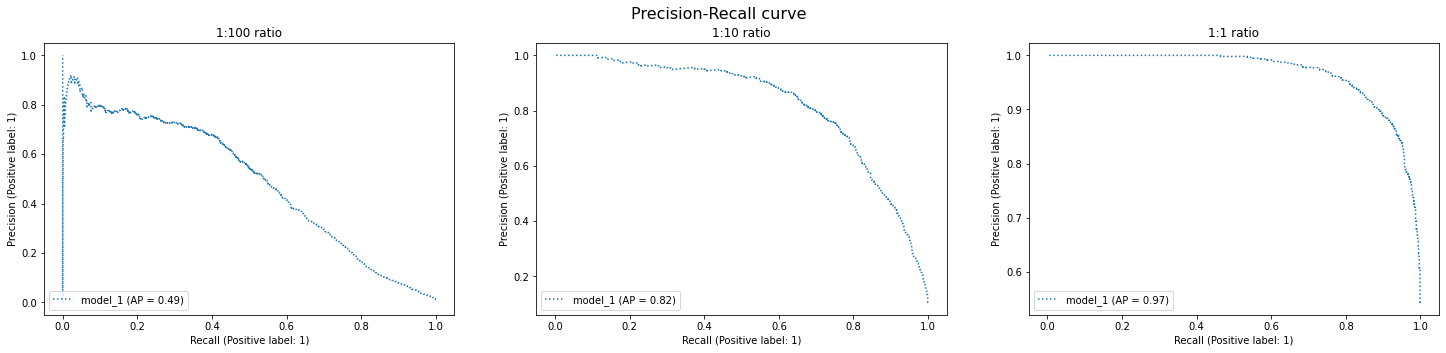

In [ ]:
test_and_plot([model], test_data_1, test_data_10, test_data_100)

### ResNet 3 *(AP100: 0.49, params: 409,093)*

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size=3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)

    return out

def create_res_net():
    
    inputs = Input(shape=(50, 20, 1))
    num_filters = 16
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = Dropout(0.15)(t)
    
    num_blocks_list = [4, 6, 4]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            t = Dropout(0.15)(t)

        num_filters *= 2

    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(1, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    return model

In [ ]:
with strategy.scope():

  model = create_res_net()
  model.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_88 (BatchN  (None, 50, 20, 1)   4           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_92 (Conv2D)             (None, 50, 20, 16)   160         ['batch_normalization_88[0][0]'] 
                                                                                                  
 re_lu_84 (ReLU)                (None, 50, 20, 16)   0           ['conv2d_92[0][0]']        

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])),

    shuffle=True,
    batch_size=128*8,

    # class_weight={
    #     0: 1,
    #     1: 100
    # },

    validation_split=0.05,

    # x=train_generator,
    # validation_data=val_generator, 
    verbose=1,
    epochs=180,
    callbacks=callbacks
    )

Epoch 1/180
293/293 [==============================] - 52s 98ms/step - loss: 0.2560 - precision: 0.0638 - recall: 0.0500 - val_loss: 0.1687 - val_precision: 0.6625 - val_recall: 0.1978
Epoch 2/180
293/293 [==============================] - 12s 42ms/step - loss: 0.1452 - precision: 0.5547 - recall: 0.2321 - val_loss: 0.2386 - val_precision: 0.3463 - val_recall: 0.5958
Epoch 3/180
293/293 [==============================] - 13s 44ms/step - loss: 0.1263 - precision: 0.6534 - recall: 0.3296 - val_loss: 0.1219 - val_precision: 0.6492 - val_recall: 0.4925
Epoch 4/180
293/293 [==============================] - 13s 44ms/step - loss: 0.1261 - precision: 0.6375 - recall: 0.3512 - val_loss: 0.1209 - val_precision: 0.7960 - val_recall: 0.3445
Epoch 5/180
293/293 [==============================] - 13s 44ms/step - loss: 0.1111 - precision: 0.7028 - recall: 0.4165 - val_loss: 0.1112 - val_precision: 0.7218 - val_recall: 0.5100
Epoch 6/180
293/293 [==============================] - 12s 42ms/step - loss

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


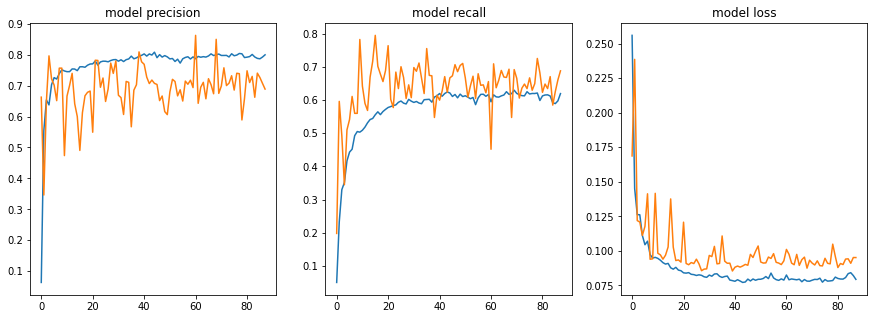

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15,5))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
ax[0].plot(history.history['precision'])
ax[0].plot(history.history['val_precision'])
ax[0].set_title('model precision')
# ax[0].ylabel('precision')
# ax[0].xlabel('epoch')
# ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for accuracy
ax[1].plot(history.history['recall'])
ax[1].plot(history.history['val_recall'])
ax[1].set_title('model recall')
# ax[1].ylabel('recall')
# ax[1].xlabel('epoch')
# ax[1].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[2].plot(history.history['loss'])
ax[2].plot(history.history['val_loss'])
ax[2].set_title('model loss')
# ax[2].ylabel('loss')
# ax[2].xlabel('epoch')
# ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

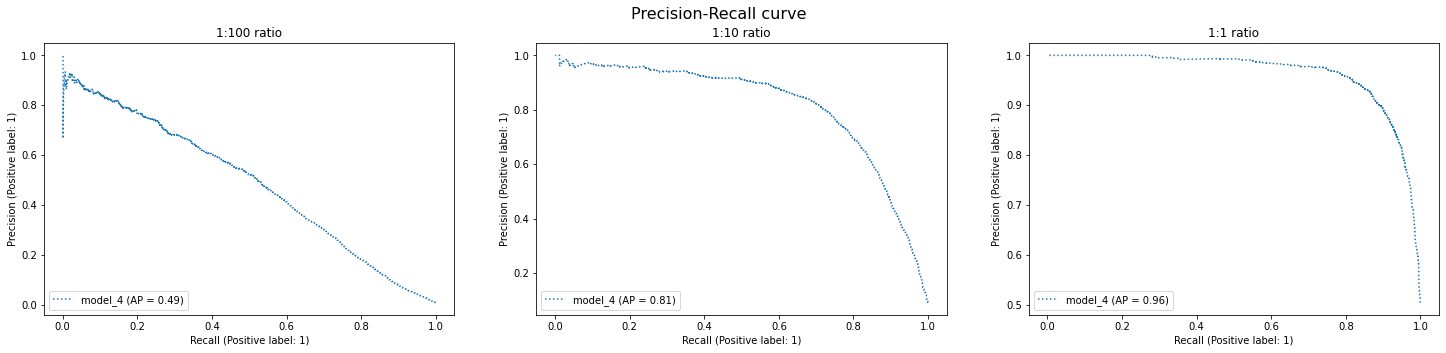

In [ ]:
test_and_plot([model], test_data_1, test_data_10, test_data_100)

### ResNet 4 *(AP100: 0.51, params: 1,476,357)*

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size=3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)

    return out

def create_res_net():
    
    inputs = Input(shape=(50, 20, 1))
    num_filters = 32
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = Dropout(0.1)(t)
    
    num_blocks_list = [4, 4, 4]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            t = Dropout(0.1 + ((i + 1) * 0.1))(t)

        num_filters *= 2

    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(1, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    return model

In [ ]:
with strategy.scope():

  model = create_res_net()
  model.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 20, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 50, 20, 32)   320         ['batch_normalization[0][0]']    
                                                                                                  
 re_lu (ReLU)                   (None, 50, 20, 32)   0           ['conv2d[0][0]']             

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])),

    shuffle=True,
    batch_size=128*8,

    # class_weight={
    #     0: 1,
    #     1: 100
    # },

    validation_split=0.05,

    # x=train_generator,
    # validation_data=val_generator, 
    verbose=1,
    epochs=180,
    callbacks=callbacks
    )

Epoch 1/180
432/432 [==============================] - 61s 90ms/step - loss: 0.2414 - precision: 0.0309 - recall: 0.0430 - val_loss: 0.2521 - val_precision: 0.0274 - val_recall: 0.0026
Epoch 2/180
432/432 [==============================] - 22s 52ms/step - loss: 0.1330 - precision: 0.4159 - recall: 0.0265 - val_loss: 0.1632 - val_precision: 0.9000 - val_recall: 0.0119
Epoch 3/180
432/432 [==============================] - 22s 52ms/step - loss: 0.0892 - precision: 0.6285 - recall: 0.2883 - val_loss: 0.1321 - val_precision: 0.3759 - val_recall: 0.7160
Epoch 4/180
432/432 [==============================] - 22s 50ms/step - loss: 0.1185 - precision: 0.4880 - recall: 0.2733 - val_loss: 4.6054 - val_precision: 0.0338 - val_recall: 0.9789
Epoch 5/180
432/432 [==============================] - 22s 50ms/step - loss: 0.1183 - precision: 0.5382 - recall: 0.1131 - val_loss: 0.1568 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/180
432/432 [==============================] - 22s 50ms/ste

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


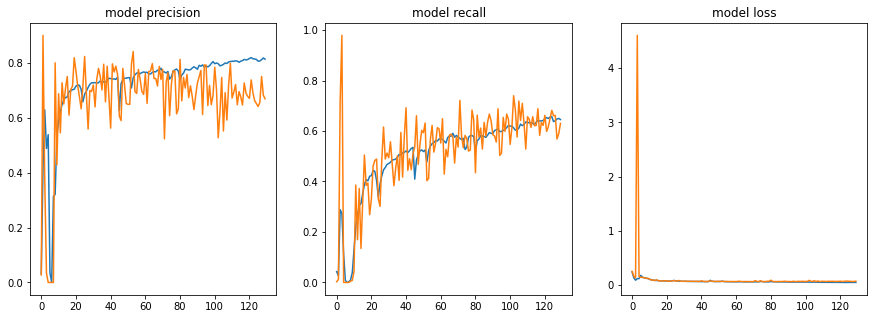

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15,5))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
ax[0].plot(history.history['precision'])
ax[0].plot(history.history['val_precision'])
ax[0].set_title('model precision')
# ax[0].ylabel('precision')
# ax[0].xlabel('epoch')
# ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for accuracy
ax[1].plot(history.history['recall'])
ax[1].plot(history.history['val_recall'])
ax[1].set_title('model recall')
# ax[1].ylabel('recall')
# ax[1].xlabel('epoch')
# ax[1].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[2].plot(history.history['loss'])
ax[2].plot(history.history['val_loss'])
ax[2].set_title('model loss')
# ax[2].ylabel('loss')
# ax[2].xlabel('epoch')
# ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

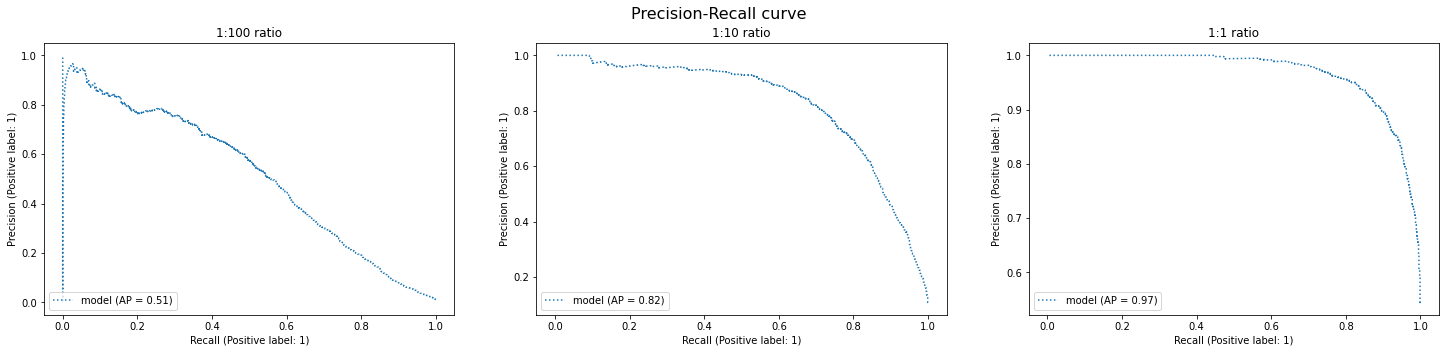

In [ ]:
test_and_plot([model], test_data_1, test_data_10, test_data_100)

### ResNet 5 *(AP100: 0.50, params: 409,093)*

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample, filters, kernel_size=3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)

    return out

def create_res_net():
    
    inputs = Input(shape=(50, 20, 1))
    num_filters = 16
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = Dropout(0.15)(t)
    
    num_blocks_list = [4, 6, 4]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            t = Dropout(0.15 + (i * 0.05))(t)

        num_filters *= 2

    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(1, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    return model

In [ ]:
with strategy.scope():

  model = create_res_net()
  model.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 20, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 50, 20, 16)   160         ['batch_normalization[0][0]']    
                                                                                                  
 re_lu (ReLU)                   (None, 50, 20, 16)   0           ['conv2d[0][0]']             

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])),

    shuffle=True,
    batch_size=128*8,

    # class_weight={
    #     0: 1,
    #     1: 100
    # },

    validation_split=0.05,

    # x=train_generator,
    # validation_data=val_generator, 
    verbose=1,
    epochs=180,
    callbacks=callbacks
    )

Epoch 1/180
293/293 [==============================] - 49s 93ms/step - loss: 0.2104 - precision: 0.1796 - recall: 0.0884 - val_loss: 0.2860 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/180
293/293 [==============================] - 12s 42ms/step - loss: 0.1313 - precision: 0.6205 - recall: 0.3004 - val_loss: 0.1218 - val_precision: 0.6460 - val_recall: 0.4274
Epoch 3/180
293/293 [==============================] - 12s 42ms/step - loss: 0.1157 - precision: 0.6907 - recall: 0.3970 - val_loss: 0.1117 - val_precision: 0.8306 - val_recall: 0.3425
Epoch 4/180
293/293 [==============================] - 12s 40ms/step - loss: 0.1069 - precision: 0.7073 - recall: 0.4389 - val_loss: 0.1682 - val_precision: 0.3738 - val_recall: 0.7932
Epoch 5/180
293/293 [==============================] - 12s 42ms/step - loss: 0.1038 - precision: 0.7112 - recall: 0.4594 - val_loss: 0.1059 - val_precision: 0.5672 - val_recall: 0.6589
Epoch 6/180
293/293 [==============================] - 13s 44ms/ste

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


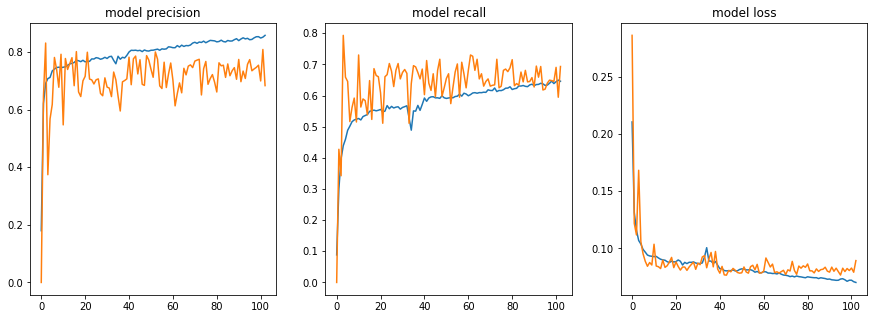

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15,5))

# list all data in history
print(history.history.keys())

# summarize history for accuracy
ax[0].plot(history.history['precision'])
ax[0].plot(history.history['val_precision'])
ax[0].set_title('model precision')
# ax[0].ylabel('precision')
# ax[0].xlabel('epoch')
# ax[0].legend(['train', 'test'], loc='upper left')

# summarize history for accuracy
ax[1].plot(history.history['recall'])
ax[1].plot(history.history['val_recall'])
ax[1].set_title('model recall')
# ax[1].ylabel('recall')
# ax[1].xlabel('epoch')
# ax[1].legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax[2].plot(history.history['loss'])
ax[2].plot(history.history['val_loss'])
ax[2].set_title('model loss')
# ax[2].ylabel('loss')
# ax[2].xlabel('epoch')
# ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

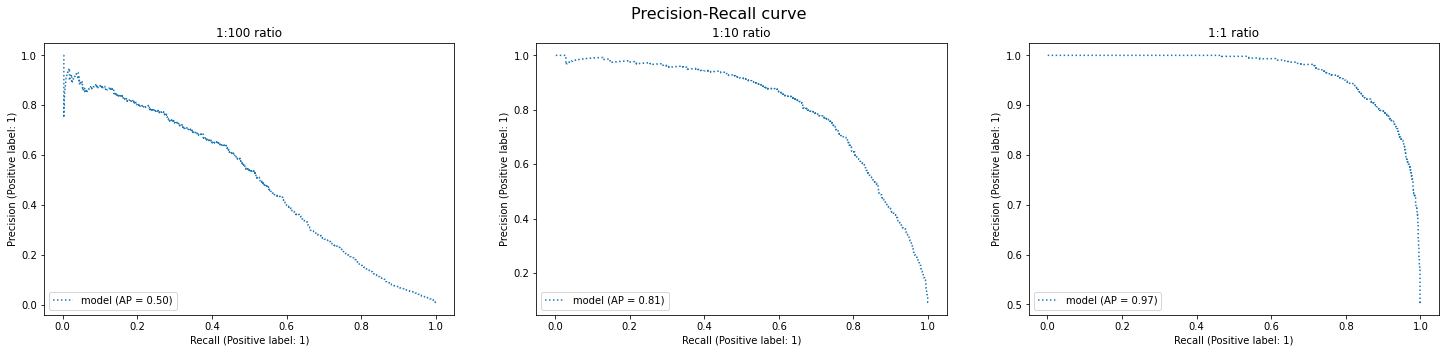

In [ ]:
test_and_plot([model], test_data_1, test_data_10, test_data_100)

In [ ]:
model.save("resnet_small_50_auc.h5")

## Inception

In [ ]:
from tensorflow.keras import layers

"""
This function creates a modified Inception model. Code used here is a changed version from Keras GitHub.

source: https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py

"""


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
  """Utility function to apply conv + BN.
  Args:
    x: input tensor.
    filters: filters in `Conv2D`.
    num_row: height of the convolution kernel.
    num_col: width of the convolution kernel.
    padding: padding mode in `Conv2D`.
    strides: strides in `Conv2D`.
    name: name of the ops; will become `name + '_conv'`
      for the convolution and `name + '_bn'` for the
      batch norm layer.
  Returns:
    Output tensor after applying `Conv2D` and `BatchNormalization`.
  """
  if name is not None:
    bn_name = name + '_bn'
    conv_name = name + '_conv'
  else:
    bn_name = None
    conv_name = None

  bn_axis = 3
  x = layers.Conv2D(
      filters, (num_row, num_col),
      strides=strides,
      padding=padding,
      use_bias=False,
      name=conv_name)(
          x)
  x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
  x = layers.Activation('relu', name=name)(x)
  
  # x = Dropout(0.25)(x)

  return x

In [ ]:
def InceptionV3(
    input_shape=None,
    classes=1,
    classifier_activation='sigmoid'):

    input = layers.Input(shape=input_shape)
    channel_axis = 3

  # Skipped because of too large dim reduction
  #   
  # x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
  # x = conv2d_bn(x, 32, 3, 3, padding='valid')
  # x = conv2d_bn(x, 64, 3, 3)
  # x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

  # x = conv2d_bn(x, 80, 1, 1, padding='valid')
  # x = conv2d_bn(x, 192, 3, 3, padding='valid')
  # x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0: 50 x 20
    branch1x1 = conv2d_bn(input, 64, 1, 1)

    branch5x5 = conv2d_bn(input, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(input, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(input)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed0')
    
    x = Dropout(0.25)(x)

    # mixed 1: 50 x 20
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed1')
    
    x = Dropout(0.25)(x)

    # mixed 2: 50 x 20
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed2')
    
    x = Dropout(0.25)(x)

    # mixed 3: 25 x 10
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch3x3dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed3')
    
    x = Dropout(0.25)(x)

    # mixed 4: 25 x 10
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D(
        (3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                            axis=channel_axis,
                            name='mixed4')
    
    x = Dropout(0.25)(x)

  # # mixed 5, 6: 25 x 10
  #   for i in range(2):
  #       branch1x1 = conv2d_bn(x, 192, 1, 1)

  #       branch7x7 = conv2d_bn(x, 160, 1, 1)
  #       branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
  #       branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

  #       branch7x7dbl = conv2d_bn(x, 160, 1, 1)
  #       branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
  #       branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
  #       branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
  #       branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

  #       branch_pool = layers.AveragePooling2D((3, 3),
  #                                               strides=(1, 1),
  #                                               padding='same')(
  #                                                   x)
  #       branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
  #       x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
  #                               axis=channel_axis,
  #                               name='mixed' + str(5 + i))

  #   # mixed 7: 25 x 10
  #   branch1x1 = conv2d_bn(x, 192, 1, 1)

  #   branch7x7 = conv2d_bn(x, 192, 1, 1)
  #   branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
  #   branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

  #   branch7x7dbl = conv2d_bn(x, 192, 1, 1)
  #   branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
  #   branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
  #   branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
  #   branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

  #   branch_pool = layers.AveragePooling2D(
  #       (3, 3), strides=(1, 1), padding='same')(x)
  #   branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
  #   x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
  #                           axis=channel_axis,
  #                           name='mixed7')

  #   # mixed 8: 13 x 5
  #   branch3x3 = conv2d_bn(x, 192, 1, 1)
  #   branch3x3 = conv2d_bn(branch3x3, 320, 3, 3, strides=(2, 2), padding='valid')

  #   branch7x7x3 = conv2d_bn(x, 192, 1, 1)
  #   branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
  #   branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
  #   branch7x7x3 = conv2d_bn(
  #       branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

  #   branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
  #   x = layers.concatenate([branch3x3, branch7x7x3, branch_pool],
  #                           axis=channel_axis,
  #                           name='mixed8')

  #   # mixed 9: 13 x 5
  #   for i in range(2):

  #       branch1x1 = conv2d_bn(x, 320, 1, 1)

  #       branch3x3 = conv2d_bn(x, 384, 1, 1)
  #       branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
  #       branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
  #       branch3x3 = layers.concatenate([branch3x3_1, branch3x3_2],
  #                                       axis=channel_axis,
  #                                       name='mixed9_' + str(i))

  #       branch3x3dbl = conv2d_bn(x, 448, 1, 1)
  #       branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
  #       branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
  #       branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
  #       branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2],
  #                                           axis=channel_axis)

  #       branch_pool = layers.AveragePooling2D((3, 3),
  #                                               strides=(1, 1),
  #                                               padding='same')(
  #                                                   x)
  #       branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
  #       x = layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool],
  #                               axis=channel_axis,
  #                               name='mixed' + str(9 + i))

    # Classification block
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    # imagenet_utils.validate_activation(classifier_activation, weights)
    x = layers.Dense(classes, activation=classifier_activation,
                        name='predictions')(x)
  
    # Create model.
    model = tf.keras.Model(input, x, name='inception_v3')

    return model

In [ ]:
# Prepare undersampled data

df_train = pd.concat([
    df[(df['label'] == 0)].sample(n=300000, random_state=3167),

    # Use all hard and positive samples
    # df[(df['label'] == 0) & (df['ih'] > 0.1)].sample(frac=1.),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1.0)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

print(f"Using {df_train.shape[0]} training samples.")

Using 315392 training samples.


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data = df_train[['miRNA', 'gene', 'label']].progress_apply(lambda row: encode_and_label(row, label_col="label"), axis=1, result_type='expand')

Encoding training data:   0%|          | 0/315392 [00:00<?, ?it/s]

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.0001, 
        patience=15, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
with strategy.scope():
  model = InceptionV3(input_shape=(50, 20, 1), classes=1, classifier_activation="sigmoid")
  model.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      precision_,
                      recall_
                      ]
      })
  # model.summary()


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 50, 20, 64)   64          ['input_1[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 50, 20, 64)  192         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 50, 20, 64)   0           ['batch_normalization_

In [ ]:
history = model.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8,
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
293/293 [==============================] - 107s 277ms/step - loss: 0.1272 - precision_: 0.6067 - recall_: 0.3433 - val_loss: 0.2171 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
293/293 [==============================] - 52s 178ms/step - loss: 0.0909 - precision_: 0.7626 - recall_: 0.5292 - val_loss: 0.0972 - val_precision_: 0.6985 - val_recall_: 0.5980
Epoch 3/1000
293/293 [==============================] - 52s 177ms/step - loss: 0.0850 - precision_: 0.7694 - recall_: 0.5595 - val_loss: 0.0925 - val_precision_: 0.7456 - val_recall_: 0.5750
Epoch 4/1000
293/293 [==============================] - 51s 174ms/step - loss: 0.0812 - precision_: 0.7811 - recall_: 0.5879 - val_loss: 0.1020 - val_precision_: 0.6496 - val_recall_: 0.6944
Epoch 5/1000
293/293 [==============================] - 51s 174ms/step - loss: 0.0789 - precision_: 0.7886 - recall_: 0.6037 - val_loss: 0.1185 - val_precision_: 0.5735 - val_recall_: 0.8079
Epoch 6/1000
293/293 [==============

dict_keys(['loss', 'precision_', 'recall_', 'val_loss', 'val_precision_', 'val_recall_'])


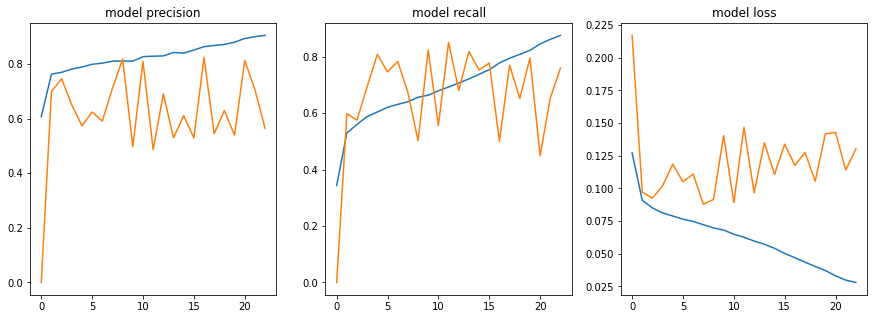

In [ ]:
plot_training(history)

In [ ]:
model.save(f"{dir_path}/inception.h5")

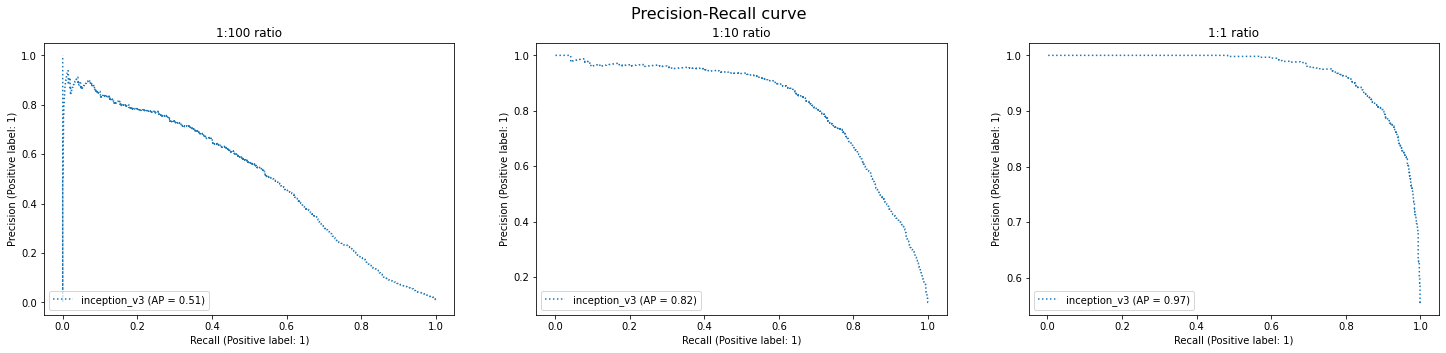

In [ ]:
# Original architecture + Dropout 0.25 added
test_and_plot([model], test_data_1, test_data_10, test_data_100)

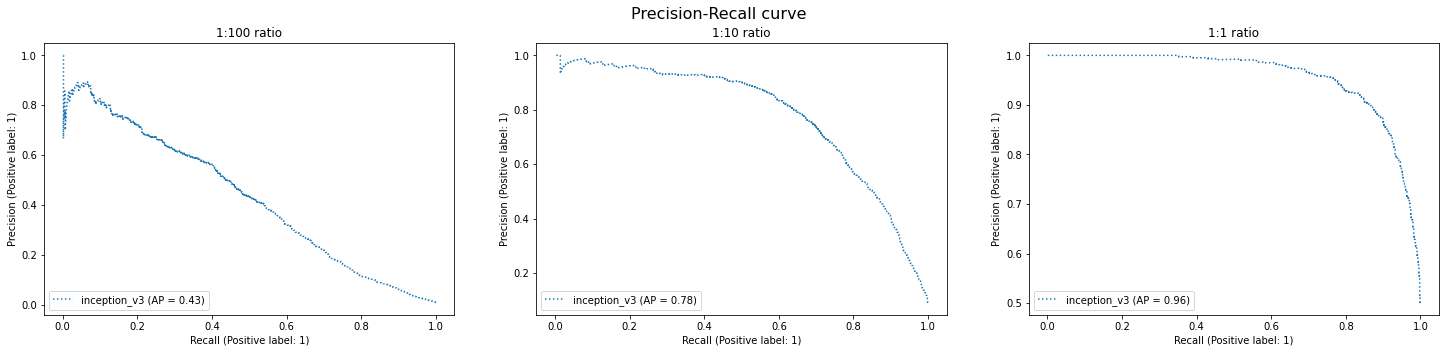

In [ ]:
# Original architecture
test_and_plot([model], test_data_1, test_data_10, test_data_100)